In [30]:
import pandas as pd
import numpy as np
import joblib
import json 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.svm import SVC 
from sklearn.neural_network import  MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns 
import matplotlib.pyplot as plt 


In [8]:
def predict_tournament_games(year, model_path="best_xgb_model.model", best_features_path="best_features.json", data_path="../data/modeling/final_ml.csv", teams_path="../data/MTeams.csv"):
    # Load the data
    df_test = pd.read_csv(data_path)
    df_seeds = df_test[['Team1', 'Team2', 'Season', 'Seed_1', 'Seed_2']]
    df_test = pd.get_dummies(df_test, columns=['Seed_1', 'Seed_2'], prefix=['T1_Seed','T2_Seed'], dtype=int)

    MTeams = pd.read_csv(teams_path)
    MTeams.drop(columns=['FirstD1Season', 'LastD1Season'], inplace=True)

    # Load the best features from JSON
    with open(best_features_path, "r") as f:
        best_features = json.load(f)

    # Extract the selected features
    select_features = ['reg_season_pred']
    best_feats = best_features["selected_features"]
    selected_features = select_features + best_feats

    print("Selected Features:", selected_features)

        # Extract the Brier score for the specified year
    brier_score_for_year = None
    for entry in best_features["brier_scores"]:
        if entry["season"] == year:
            brier_score_for_year = entry["brier_score"]
            break

    print(f"Season {year} Brier Score: {brier_score_for_year}")
    print(f"Brier Score on test set: {best_features['brier_score']}")

    seed_columns = [col for col in df_test.columns if 'seed' in col.lower()]
    feature_columns = selected_features + seed_columns

    # Filter games for the specified year
    tourney_year_data = df_test[df_test['Season'] == year]

    # Prepare test data
    X_year = tourney_year_data[feature_columns]
    y_year = tourney_year_data['Team1_Wins']

    # Load the trained model
    loaded_model = xgb.XGBClassifier()
    loaded_model.load_model(model_path)

    # Get predicted probabilities for the year's games
    y_pred_probs_year = loaded_model.predict_proba(X_year)[:, 1]  # Prob for Team1 winning

    # Create a DataFrame with results
    predictions_year = pd.DataFrame({
        'Team1_Wins': y_year,
        'Predicted_Prob_Team1_Wins': y_pred_probs_year,
        'Team1': tourney_year_data['Team1'], 
        'Team2': tourney_year_data['Team2'], 
        'Season': year
    })

    # Merge with seed data
    predictions_year = predictions_year.merge(df_seeds, on=['Team1', 'Team2', 'Season'], how='left')

    # Merge with team names
    predictions_year = predictions_year.merge(MTeams, how='left', right_on=['TeamID'], left_on=['Team1'])
    predictions_year = predictions_year.rename(columns={'TeamName': 'TeamName_1'})

    predictions_year = predictions_year.merge(MTeams, how='left', right_on=['TeamID'], left_on=['Team2'])
    predictions_year = predictions_year.rename(columns={'TeamName': 'TeamName_2'})
    predictions_year = predictions_year[predictions_year['Team1_Wins'] == 1]

    # Clean up the DataFrame
    predictions_year.drop(columns=['TeamID_x', 'TeamID_y'], inplace=True)
    predictions_year = predictions_year.reindex(columns=[
        'Seed_1', 'Team1', 'TeamName_1', 'Seed_2', 'Team2', 'TeamName_2', 
        'Predicted_Prob_Team1_Wins', 'Team1_Wins'
    ])

    return predictions_year

In [27]:
# Example usage
year = 2024
model_path = "best_xgb_model.model"
best_features_path = "best_features.json"
data_path = "../data/modeling/final_ml.csv"
teams_path = "../data/MTeams.csv"

predictions = predict_tournament_games(year)

# Show all rows
pd.set_option("display.max_rows", None)
predictions

Selected Features: ['reg_season_pred', 'Offensive_Rebound_Rate_1', 'Offensive_Rebound_Rate_2', 'Win_Percentage_1', 'Win_Percentage_2', 'FTr_1', 'FTr_2', 'SRS_1', 'SRS_2', 'Opp_Free_Throws_Per_Game_1', 'Opp_Free_Throws_Per_Game_2', 'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2']
Season 2024 Brier Score: 0.15374802065135434
Brier Score on test set: 0.18428803770201727


,Seed_1,Team1,TeamName_1,Seed_2,Team2,TeamName_2,Predicted_Prob_Team1_Wins,Team1_Wins
0,10,1161,Colorado St,10,1438,Virginia,0.562925,1
1,16,1447,Wagner,16,1224,Howard,0.584274,1
2,10,1160,Colorado,10,1129,Boise St,0.638901,1
3,16,1212,Grambling,16,1286,Montana St,0.480325,1
4,2,1112,Arizona,15,1253,Long Beach St,0.931818,1
5,3,1166,Creighton,14,1103,Akron,0.886754,1
6,7,1173,Dayton,10,1305,Nevada,0.578569,1
7,11,1182,Duquesne,6,1140,BYU,0.360466,1
8,5,1211,Gonzaga,12,1270,McNeese St,0.783290,1
9,3,1228,Illinois,14,1287,Morehead St,0.902711,1


In [18]:
pd.set_option("display.max_columns", None) 
df_full = pd.read_csv("../data/modeling/final_ml.csv")


df_tune = df_full.drop(columns=['Team1', 'Team2', 'ConfAbbrev_1', 'ConfAbbrev_2', 'Threes_Per_Game_1', 'Threes_Per_Game_2', 'Free_Throws_Per_Game_1', 'Free_Throws_Per_Game_2'])
df_tune = df_tune[[
    'Season', 'Team1_Wins', 'Seed_1', 'Seed_2', 'reg_season_pred',
    'SRS_1', 'SRS_2', 'Offensive_Rebound_Rate_1', 'Offensive_Rebound_Rate_2', 'Win_pct_last_10_games_1', 'Win_pct_last_10_games_2', 'Turnovers_Per_Game_1', 'Turnovers_Per_Game_2', 'Pace_1', 'Pace_2', 'FTr_1', 'FTr_2', '3PAr_1', '3PAr_2', 'Three_Point_Percentage_1', 'Three_Point_Percentage_2'
]]
df_tune = pd.get_dummies(df_tune, columns=['Seed_1', 'Seed_2'], prefix=['T1_Seed','T2_Seed'], dtype=int)

X = df_tune.drop(columns=['Season','Team1_Wins'])
y = df_tune['Team1_Wins']
df_full.head(5) 

,Season,DayNum,Team1,Team2,Team1_Wins,Win_Percentage_1,Points_Per_Game_1,FG_Percentage_1,Threes_Per_Game_1,Three_Point_Percentage_1,Free_Throws_Per_Game_1,Free_Throw_Percentage_1,Offensive_Rebound_Rate_1,Defensive_Rebound_Rate_1,Turnovers_Per_Game_1,Opp_FG_Percentage_1,Opp_Three_Point_Percentage_1,Opp_Free_Throws_Per_Game_1,Opp_Turnovers_Per_Game_1,ConfAbbrev_1,Win_pct_last_10_games_1,SRS_1,SOS_1,Pace_1,FTr_1,3PAr_1,offensiveRating_1,defensiveRating_1,Win_Percentage_2,Points_Per_Game_2,FG_Percentage_2,Threes_Per_Game_2,Three_Point_Percentage_2,Free_Throws_Per_Game_2,Free_Throw_Percentage_2,Offensive_Rebound_Rate_2,Defensive_Rebound_Rate_2,Turnovers_Per_Game_2,Opp_FG_Percentage_2,Opp_Three_Point_Percentage_2,Opp_Free_Throws_Per_Game_2,Opp_Turnovers_Per_Game_2,ConfAbbrev_2,Win_pct_last_10_games_2,SRS_2,SOS_2,Pace_2,FTr_2,3PAr_2,offensiveRating_2,defensiveRating_2,Seed_1,Seed_2,reg_season_pred
0,2014,134,1107,1291,1,0.562500,66.031250,43.914373,13.468750,36.426914,21.718750,74.820144,32.387476,70.905764,12.625000,41.863140,35.247209,15.843750,11.968750,aec,0.7,-3.31,-5.22,63.1,0.420,0.261,110.7,110.2,0.500000,76.250000,44.068706,24.906250,35.633626,21.687500,74.063401,28.345070,66.855524,12.000000,49.312896,33.626374,20.312500,13.281250,nec,0.6,-6.32,-4.44,70.0,0.367,0.434,112.5,112.6,16,16,0.568295
1,2014,134,1301,1462,1,0.617647,70.794118,45.865434,14.764706,30.278884,20.852941,66.149506,34.790060,63.735343,10.411765,42.438765,31.951641,23.794118,11.529412,acc,0.5,9.02,7.44,64.9,0.370,0.255,111.1,110.9,0.636364,72.212121,47.130919,14.727273,35.390947,22.848485,68.832891,34.105653,71.216098,12.363636,42.714127,35.394127,21.696970,11.272727,big_east,0.5,11.84,8.14,65.7,0.416,0.270,111.6,110.9,12,12,0.433937
2,2014,135,1142,1411,1,0.366667,62.000000,40.371517,18.900000,33.509700,17.766667,68.667917,30.842912,66.953714,8.966667,43.837442,33.978495,21.466667,10.833333,big_west,0.5,-1.34,1.69,60.8,0.326,0.354,110.2,110.9,0.562500,75.062500,45.821326,17.593750,35.879218,26.812500,71.095571,33.456905,68.924640,13.218750,44.632768,35.528596,17.906250,10.843750,swac,0.9,-8.41,-10.07,68.2,0.491,0.325,111.9,112.3,16,16,0.730664
3,2014,135,1397,1234,1,0.625000,70.500000,44.249292,16.875000,32.962963,22.781250,70.781893,39.692586,72.423146,10.875000,41.238318,34.047109,17.687500,10.843750,sec,0.6,17.34,7.84,62.8,0.416,0.308,112.2,109.1,0.625000,82.000000,46.469367,16.562500,35.283019,27.593750,73.272933,38.107639,71.063479,11.375000,41.401274,31.954351,20.500000,13.468750,big_ten,0.3,18.58,7.43,69.8,0.453,0.275,113.3,110.1,11,11,0.473278
4,2014,136,1163,1386,1,0.764706,71.852941,44.835046,18.382353,38.720000,21.000000,76.050420,31.238616,66.563467,11.676471,38.733126,32.894737,20.088235,12.911765,aac,0.7,17.23,8.63,65.5,0.383,0.343,111.4,107.7,0.727273,71.272727,46.858790,19.363636,38.028169,22.818182,64.143426,29.488372,72.393661,12.333333,41.842105,33.742331,17.636364,10.151515,a_ten,0.8,9.05,5.08,66.0,0.436,0.369,111.4,110.2,7,10,0.693183


XGBoost Brier Score: 0.1711
XGBoost Accuracy: 0.7239
XGBoost Log Loss: 0.5124
XGBoost ROC-AUC Score: 0.8234


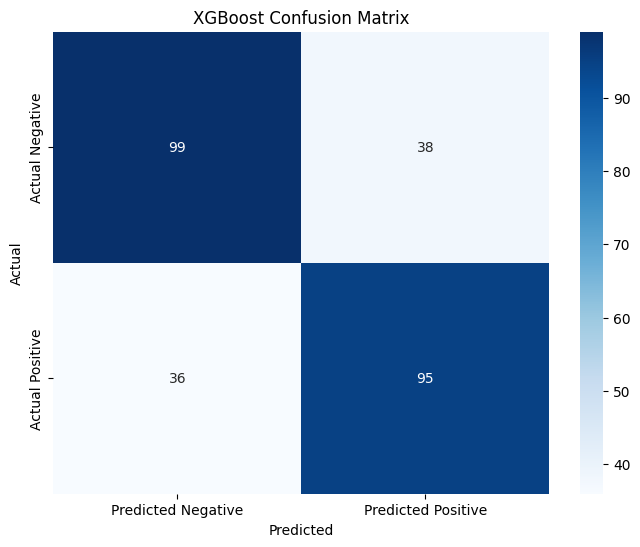

In [26]:
# Train the tuned XGBoost model
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)


xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    subsample=0.625, n_estimators=600, min_child_weight=9, max_depth=3,
    learning_rate=0.01, 
    colsample_bytree=0.5,
    random_state=49,
    # Set other parameters to match the JSON
    base_score=None,
    booster=None,
    colsample_bylevel=None,
    colsample_bynode=None,
    gamma=None,
    grow_policy=None,
    importance_type=None,
    max_bin=None,
    max_cat_threshold=None,
    max_cat_to_onehot=None,
    max_delta_step=None,
    max_leaves=None,
    missing= float('nan'),
    monotone_constraints=None,
    num_parallel_tree=None,
    reg_alpha=None,
    reg_lambda=None,
    scale_pos_weight=None,
    tree_method=None,
    validate_parameters=None,
    verbosity=None
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
xgb_brier = brier_score_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Brier Score: {xgb_brier:.4f}')

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')

xgb_logloss = log_loss(y_test, y_pred_probs_xgb)
print(f'XGBoost Log Loss: {xgb_logloss:.4f}')

xgb_auc = roc_auc_score(y_test, y_pred_probs_xgb)
print(f'XGBoost ROC-AUC Score: {xgb_auc:.4f}')

# Calculate and display the confusion matrix
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()


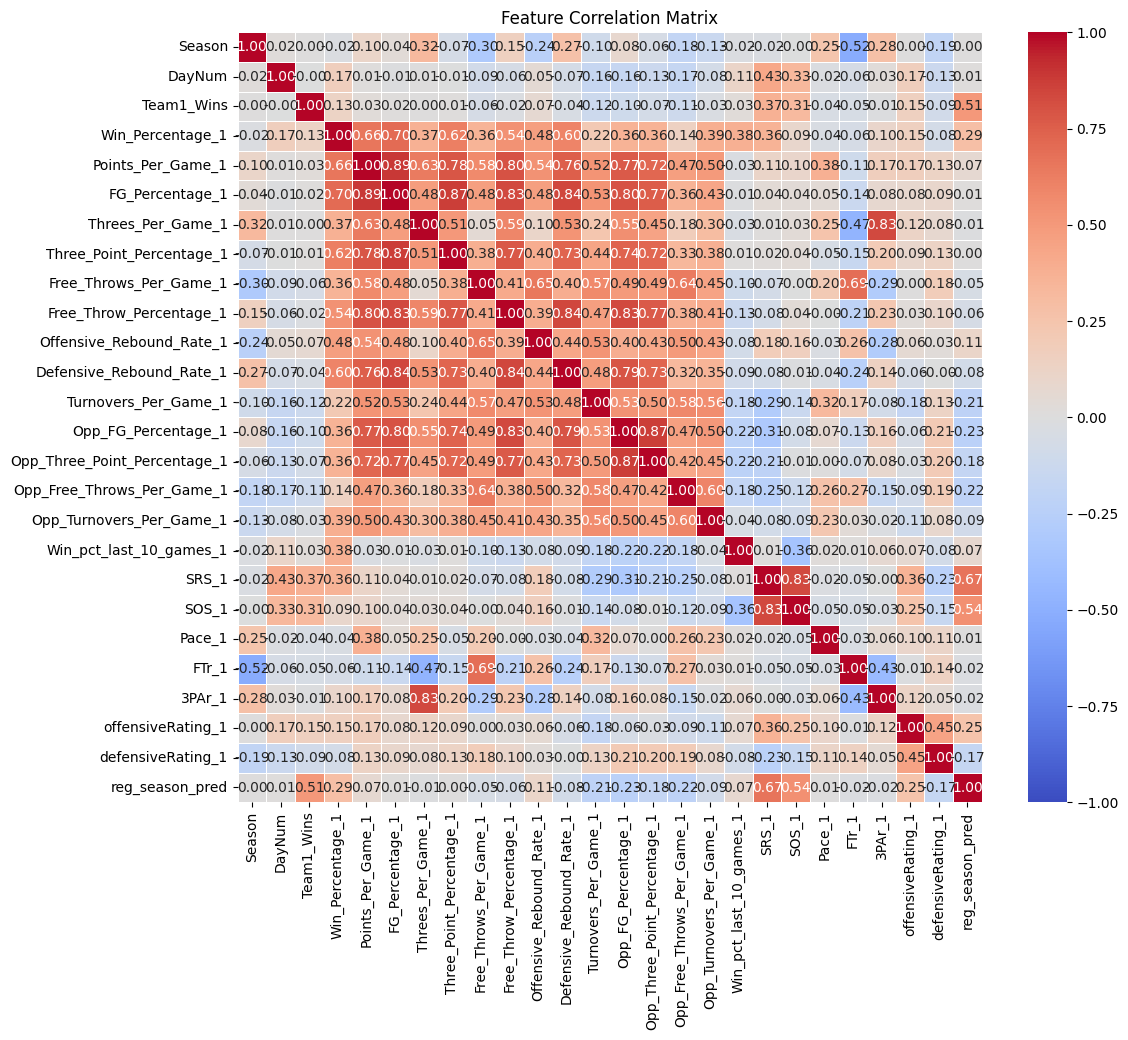

In [28]:
columns_to_drop = ['Team1', 'Team2', 'Seed_1', 'Seed_2', 'ConfAbbrev_1', 'ConfAbbrev_2']
columns_to_drop += [col for col in df_full.columns if col.endswith('_2')]

# Calculate the correlation matrix
df_corr = df_full.drop(columns=columns_to_drop)
correlation_matrix = df_corr.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Add title and labels
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Set a correlation threshold
threshold = 0.8

# Find highly correlated features
highly_correlated = set()  # Use a set to avoid duplicate pairs

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated.add((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Convert the set to a list and sort by correlation in descending order
highly_correlated_sorted = sorted(highly_correlated, key=lambda x: abs(x[2]), reverse=True)

# Display highly correlated feature pairs in descending order
print("Highly Correlated Feature Pairs (Descending Order):")
for pair in highly_correlated_sorted:
    print(f"{pair[0]} and {pair[1]} (Correlation: {pair[2]:.2f})")

In [29]:
pd.set_option("display.max_rows", None) 

# Assuming xgb_model is your trained XGBoost model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': xgb_model.feature_importances_
})

# Sort by importance (ascending or descending)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Show all rows
pd.set_option("display.max_rows", None)
print(feature_importance)


                     Feature  Importance
0            reg_season_pred    0.092596
17                 T1_Seed_1    0.071339
33                 T2_Seed_1    0.061939
1                      SRS_1    0.052134
2                      SRS_2    0.050800
18                 T1_Seed_2    0.049658
19                 T1_Seed_3    0.047751
20                 T1_Seed_4    0.039852
36                 T2_Seed_4    0.030601
27                T1_Seed_11    0.028365
22                 T1_Seed_6    0.027121
34                 T2_Seed_2    0.026139
5    Win_pct_last_10_games_1    0.025265
11                     FTr_1    0.025170
9                     Pace_1    0.024986
43                T2_Seed_11    0.024782
8       Turnovers_Per_Game_2    0.023754
4   Offensive_Rebound_Rate_2    0.023658
14                    3PAr_2    0.023488
7       Turnovers_Per_Game_1    0.023179
39                 T2_Seed_7    0.023116
6    Win_pct_last_10_games_2    0.022798
12                     FTr_2    0.022700
13              